### Stokes flow

\begin{align*}
    \mu \nabla \cdot (\nabla v + \nabla v^T) - \nabla p &= 0 \\
    \nabla \cdot v &=0
\end{align*}

Domain = (0, w) x (0, h) 

No slip at bottom and top boundary, left inflow and right free outflow


In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0" # select GPUs to use
import torch
import pytorch_lightning as pl
import torchphysics as tp

In [2]:
width, height = 2.0, 1.0
mu = 1.0

V = tp.spaces.R2('v')
# Horizontal flow component is v[:, :1], vertical is v[:, 1:]
P = tp.spaces.R1('p')
X = tp.spaces.R2('x')

# If force term is unknown:
#F = tp.spaces.R2('f')
## Or as a fixed parameter:
#f = torch.tensor([0, -1])
#f = f.cuda() # or for some constant gravity
# Horizontal force component is f[:, :1], vertical is f[:, 1:]

In [3]:
box = tp.domains.Parallelogram(X, [0.0, 0.0], [width, 0.0], [0.0, height])

In [4]:
model = tp.models.FCN(X, V*P, hidden=(25,25,25))
## If f is parameter that should be learned:
#param_f = tp.models.Parameter(init=[1.0, 1.0], space=F)
## If f is also dependend on x:
#model_f = tp.models.FCN(X, F, hidden=(25,25,25))
#both_models = tp.models.Parallel(model, model_f)

In [5]:
inner_sampler = tp.samplers.RandomUniformSampler(box, n_points=20000)

def pde_residual(v, p, x): # f here as an input for inverse problem
    p_x = tp.utils.grad(p, x)
    v_lap = tp.utils.matrix_div(tp.utils.sym_grad(v, x), x)
    return mu * v_lap - p_x #- f

pde_condition = tp.conditions.PINNCondition(model, inner_sampler, pde_residual) # also here


def div_residual(v, x):
    return tp.utils.div(v, x)

div_condition = tp.conditions.PINNCondition(model, inner_sampler, div_residual)

In [6]:
# Filter for boundary
def filter_top_bottom(x):
    return (x[:, 1:] <= 0.0) | (x[:, 1:] >= height)

def filter_left(x):
    return x[:, :1] <= 0

def filter_right(x):
    return x[:, :1] >= width

In [7]:
def no_slip_residual(v):
    return v

bc_sampler = tp.samplers.RandomUniformSampler(box.boundary, n_points=5000, filter_fn=filter_top_bottom)
no_slip_condition = tp.conditions.PINNCondition(model, bc_sampler, no_slip_residual)


def inflow_residual(v, x):
    # inflow should be: horizontal flow = parabolic profile
    #                   vertical flow = 0
    residual = v
    residual[:, :1] = v[:, :1] - x[:, 1:] * (height - x[:, 1:])
    return residual

inflow_sampler = tp.samplers.RandomUniformSampler(box.boundary, n_points=5000, filter_fn=filter_left)
inflow_condition = tp.conditions.PINNCondition(model, inflow_sampler, inflow_residual)


def outflow_residual(p):
    # just apply simple outflow and say p=0
    return p

outflow_sampler = tp.samplers.RandomUniformSampler(box.boundary, n_points=5000, filter_fn=filter_right)
outflow_condition = tp.conditions.PINNCondition(model, outflow_sampler, outflow_residual)

In [8]:
optim = tp.OptimizerSetting(optimizer_class=torch.optim.Adam, lr=0.001)
solver = tp.solver.Solver([pde_condition, outflow_condition, 
                           inflow_condition, no_slip_condition, 
                           div_condition],
                          optimizer_setting=optim)


trainer = pl.Trainer(gpus=1, # or None for CPU
                     max_steps=5000,
                     logger=False,
                     benchmark=True,
                     checkpoint_callback=False)
trainer.fit(solver)


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name             | Type       | Params
------------------------------------------------
0 | train_conditions | ModuleList | 1.5 K 
1 | val_conditions   | ModuleList | 0     
------------------------------------------------
1.5 K     Trainable params
0         Non-trainable params
1.5 K     Total params
0.006     Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

/home/tomfre/miniconda3/envs/bosch/lib/python3.9/site-packages/pytorch_lightning/utilities/distributed.py:69: UserWarning: The dataloader, val dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 20 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)
/home/tomfre/miniconda3/envs/bosch/lib/python3.9/site-packages/pytorch_lightning/utilities/distributed.py:69: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 20 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)


Training: 0it [00:00, ?it/s]

torch.Size([20000, 2])
torch.Size([20000, 2])
torch.Size([20000, 2])
torch.Size([20000, 2])
torch.Size([20000, 2])
torch.Size([20000, 2])
torch.Size([20000, 2])
torch.Size([20000, 2])
torch.Size([20000, 2])
torch.Size([20000, 2])
torch.Size([20000, 2])
torch.Size([20000, 2])
torch.Size([20000, 2])
torch.Size([20000, 2])
torch.Size([20000, 2])
torch.Size([20000, 2])
torch.Size([20000, 2])
torch.Size([20000, 2])
torch.Size([20000, 2])
torch.Size([20000, 2])
torch.Size([20000, 2])
torch.Size([20000, 2])
torch.Size([20000, 2])
torch.Size([20000, 2])
torch.Size([20000, 2])
torch.Size([20000, 2])
torch.Size([20000, 2])
torch.Size([20000, 2])
torch.Size([20000, 2])
torch.Size([20000, 2])
torch.Size([20000, 2])
torch.Size([20000, 2])
torch.Size([20000, 2])


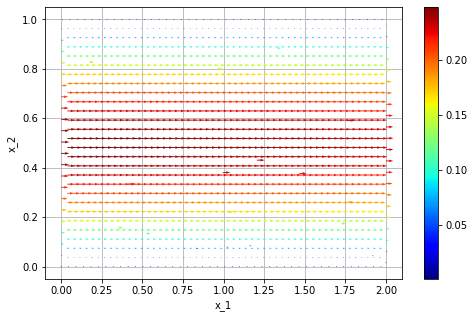

In [ ]:
plot_sampler = tp.samplers.PlotSampler(box, n_points=1500)
fig = tp.utils.plot(model, lambda v: v, plot_sampler)
fig.set_size_inches(8, 5)